<a href="https://colab.research.google.com/github/Janhavi1225-tq/coral-reef-monitoring/blob/main/coral_reef_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset

# Download the dataset
dataset = load_dataset("EPFL-ECEO/coralscapes")

# Access an image & mask
image = dataset["train"][0]["image"]
mask = dataset["train"][0]["label"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00009.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00001-of-00009.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

data/train-00002-of-00009.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

data/train-00003-of-00009.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00004-of-00009.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

data/train-00005-of-00009.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

data/train-00006-of-00009.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

data/train-00007-of-00009.parquet:   0%|          | 0.00/520M [00:00<?, ?B/s]

data/train-00008-of-00009.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

data/test-00000-of-00003.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

data/test-00001-of-00003.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

data/test-00002-of-00003.parquet:   0%|          | 0.00/358M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/392 [00:00<?, ? examples/s]

In [ ]:
# Remove the conflicting versions
!pip -q uninstall -y fsspec gcsfs

# Install versions compatible with datasets==3.0.1
!pip -q install "fsspec[http]==2024.6.1" "gcsfs==2024.6.1"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import importlib.metadata as md
print("fsspec:", md.version("fsspec"))
print("gcsfs:", md.version("gcsfs"))


fsspec: 2024.6.1
gcsfs: 2024.6.1


In [ ]:
# Make sure we have a consistent handle called `ds`
from datasets import load_dataset
ds = dataset if 'dataset' in globals() else load_dataset("EPFL-ECEO/coralscapes")

# Re-infer class IDs safely
import numpy as np
N = 300
ids = set()
split = "train"
total = len(ds[split])
limit = min(N, total)

for i in range(limit):
    m = np.array(ds[split][i]["label"])
    ids.update(np.unique(m).tolist())

class_ids = sorted(ids)
NUM_CLASSES = (max(class_ids) + 1) if (class_ids and class_ids[0] == 0) else len(class_ids)

print(f"Found class IDs in first {limit} masks:", class_ids[:50], ("..." if len(class_ids)>50 else ""))
print("NUM_CLASSES:", NUM_CLASSES)


Found class IDs in first 300 masks: [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 
NUM_CLASSES: 40


In [ ]:
import os
import numpy as np
import cv2
import tqdm

# Base directory to store images and masks
root = "/content/coralscapes"

# Create folders for train, validation, test
for split in ["train", "validation", "test"]:
    os.makedirs(f"{root}/images/{split}", exist_ok=True)
    os.makedirs(f"{root}/masks/{split}", exist_ok=True)

# Function to export each split
def export_split(split):
    dataset = ds[split]
    for i in tqdm.tqdm(range(len(dataset)), desc=f"Saving {split} data"):
        # Convert image to BGR format (required for cv2)
        image = np.array(dataset[i]["image"])[:, :, ::-1]   # RGB → BGR
        mask = np.array(dataset[i]["label"]).astype(np.uint8)

        # Save image and mask
        cv2.imwrite(f"{root}/images/{split}/{i:05d}.png", image)
        cv2.imwrite(f"{root}/masks/{split}/{i:05d}.png", mask)

# Export all splits
export_split("train")
export_split("validation")
export_split("test")

print("✅ Export completed! Files saved to:", root)


Saving test data: 100%|██████████| 392/392 [02:05<00:00,  3.14it/s]

✅ Export completed! Files saved to: /content/coralscapes


In [ ]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

# --------- config ---------
ROOT        = "/content/coralscapes"
IMG_SIZE    = 512
BATCH_SIZE  = 6
NUM_CLASSES = 40   # from your inference earlier
NUM_WORKERS = 2
# --------------------------

# Augmentations (kept realistic for underwater)
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=20, val_shift_limit=8, p=0.4),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2()
])

class ReefDataset(Dataset):
    def __init__(self, img_glob, mask_glob, tfms):
        self.imgs  = sorted(glob.glob(img_glob))
        self.masks = sorted(glob.glob(mask_glob))
        self.tfms  = tfms
        assert len(self.imgs) == len(self.masks) and len(self.imgs) > 0, "No files found or count mismatch."
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, i):
        # Read
        img  = cv2.cvtColor(cv2.imread(self.imgs[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], cv2.IMREAD_UNCHANGED).astype("int64")  # class IDs 0..NUM_CLASSES-1
        # Transform
        aug = self.tfms(image=img, mask=mask)
        x   = (aug["image"].float() / 255.0)     # [0,1]
        y   = aug["mask"].long()
        return x, y

# Build datasets
train_set = ReefDataset(f"{ROOT}/images/train/*.png",      f"{ROOT}/masks/train/*.png",      train_tfms)
val_set   = ReefDataset(f"{ROOT}/images/validation/*.png", f"{ROOT}/masks/validation/*.png", val_tfms)
test_set  = ReefDataset(f"{ROOT}/images/test/*.png",       f"{ROOT}/masks/test/*.png",       val_tfms)

# Build loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=1,          shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Quick sanity check
xb, yb = next(iter(train_loader))
print("Train batch image tensor:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())
print("Train batch mask  tensor:", yb.shape, yb.dtype, yb.min().item(), yb.max().item())
assert xb.ndim == 4 and yb.ndim == 3, "Shapes incorrect."


/tmp/ipython-input-3426178779.py:25: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),


Train batch image tensor: torch.Size([6, 3, 512, 512]) torch.float32 0.0 1.0
Train batch mask  tensor: torch.Size([6, 512, 512]) torch.int64 0 34


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model with COCO-pretrained backbone, then swap classifier to NUM_CLASSES
try:
    # Newer torchvision uses weights enums
    model = deeplabv3_resnet50(weights="DEFAULT")
except Exception:
    # Fallback for older versions
    model = deeplabv3_resnet50(pretrained=True)

in_ch = model.classifier[4].in_channels  # last conv before class logits
model.classifier[4] = nn.Conv2d(in_ch, NUM_CLASSES, kernel_size=1)
model.to(device)

# --- Loss: CrossEntropy + Soft Dice (balanced & robust) ---
ce_loss = nn.CrossEntropyLoss()

def soft_dice_loss(logits, targets, eps=1e-6):
    # logits: (N,C,H,W), targets: (N,H,W)
    probs = torch.softmax(logits, dim=1)
    onehot = torch.nn.functional.one_hot(targets, num_classes=probs.shape[1]).permute(0,3,1,2).float()
    inter = (probs * onehot).sum(dim=(0,2,3))
    denom = (probs + onehot).sum(dim=(0,2,3))
    dice = (2*inter + eps) / (denom + eps)
    return 1.0 - dice.mean()

def loss_fn(logits, targets):
    return 0.5 * ce_loss(logits, targets) + 0.5 * soft_dice_loss(logits, targets)

# --- Optimizer & mixed precision ---
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler    = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

print(f"Model ready on {device}. Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 175MB/s]


Model ready on cuda. Parameters: 42.01M


/tmp/ipython-input-242989036.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


In [ ]:
import numpy as np
import torch

def iou_per_class(preds, targets, num_classes):
    iou_sum = np.zeros(num_classes)
    iou_count = np.zeros(num_classes)

    for c in range(num_classes):
        p = (preds == c)
        t = (targets == c)
        inter = (p & t).sum().item()
        union = (p | t).sum().item()

        if union == 0:
            continue
        iou_sum[c] = inter
        iou_count[c] = union

    return iou_sum, iou_count

# --- Training variables ---
best_miou = -1
patience = 7     # stop if no improvement after 7 epochs
wait = 0
train_losses = []
val_mious = []

SAVE_PATH = "/content/best_deeplabv3_model.pth"

# --- Training loop ---
for epoch in range(60):  # can increase later, e.g., 100
    model.train()
    total_train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            outputs = model(images)["out"]  # Deeplab returns dict with "out"
            loss = loss_fn(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item() * images.size(0)

    avg_train_loss = total_train_loss / len(train_set)
    train_losses.append(avg_train_loss)

    # --- Validation for mIoU ---
    model.eval()
    iou_sum = np.zeros(NUM_CLASSES)
    iou_count = np.zeros(NUM_CLASSES)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true_masks = masks.cpu().numpy()

            # accumulate IoU stats
            for p, t in zip(preds, true_masks):
                i_sum, i_cnt = iou_per_class(p, t, NUM_CLASSES)
                iou_sum += i_sum
                iou_count += i_cnt

    # compute mean IoU
    iou_class = np.divide(iou_sum, iou_count, out=np.zeros_like(iou_sum), where=iou_count != 0)
    miou = np.nanmean(iou_class)
    val_mious.append(miou)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val mIoU: {miou:.4f}")

    # --- Save best model ---
    if miou > best_miou:
        best_miou = miou
        wait = 0
        torch.save({
            "model_state": model.state_dict(),
            "NUM_CLASSES": NUM_CLASSES
        }, SAVE_PATH)
        print("✅ Saved Best Model")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping due to no improvement")
            break

print(f"✅ Training Complete! Best mIoU: {best_miou:.4f}")


/tmp/ipython-input-577923824.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == "cuda")):


Epoch 1 | Train Loss: 1.5719 | Val mIoU: 0.0774
✅ Saved Best Model
Epoch 2 | Train Loss: 1.3705 | Val mIoU: 0.0842
✅ Saved Best Model
Epoch 3 | Train Loss: 1.3038 | Val mIoU: 0.0993
✅ Saved Best Model
Epoch 4 | Train Loss: 1.2543 | Val mIoU: 0.1207
✅ Saved Best Model
Epoch 5 | Train Loss: 1.2086 | Val mIoU: 0.1250
✅ Saved Best Model
Epoch 6 | Train Loss: 1.1883 | Val mIoU: 0.1149
Epoch 7 | Train Loss: 1.1705 | Val mIoU: 0.1257
✅ Saved Best Model
Epoch 8 | Train Loss: 1.1397 | Val mIoU: 0.1393
✅ Saved Best Model
Epoch 9 | Train Loss: 1.1267 | Val mIoU: 0.1455
✅ Saved Best Model
Epoch 10 | Train Loss: 1.0975 | Val mIoU: 0.1406
Epoch 11 | Train Loss: 1.0929 | Val mIoU: 0.1508
✅ Saved Best Model
Epoch 12 | Train Loss: 1.0776 | Val mIoU: 0.1430
Epoch 13 | Train Loss: 1.0707 | Val mIoU: 0.1588
✅ Saved Best Model
Epoch 14 | Train Loss: 1.0474 | Val mIoU: 0.1573
Epoch 15 | Train Loss: 1.0355 | Val mIoU: 0.1679
✅ Saved Best Model
Epoch 16 | Train Loss: 1.0371 | Val mIoU: 0.1645
Epoch 17 | Train

In [ ]:
import numpy as np
import torch

# Path we used in training:
SAVE_PATH = "/content/best_deeplabv3_model.pth"

# Safety: re-define IoU helper (in case kernel forgot it)
def iou_accumulate(preds, targets, num_classes):
    inter = np.zeros(num_classes, dtype=np.int64)
    union = np.zeros(num_classes, dtype=np.int64)
    for c in range(num_classes):
        p = (preds == c)
        t = (targets == c)
        inter[c] += (p & t).sum().item()
        union[c] += (p | t).sum().item()
    return inter, union

# Load best weights
ckpt = torch.load(SAVE_PATH, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

# Sweep test set
total_inter = np.zeros(NUM_CLASSES, dtype=np.int64)
total_union = np.zeros(NUM_CLASSES, dtype=np.int64)
class_support = np.zeros(NUM_CLASSES, dtype=np.int64)  # GT pixel counts

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        out = model(xb)["out"]
        pred = torch.argmax(out, dim=1).cpu()
        gt   = yb.cpu()

        inter, union = iou_accumulate(pred, gt, NUM_CLASSES)
        total_inter += inter
        total_union += union
        # accumulate GT supports
        for c in range(NUM_CLASSES):
            class_support[c] += (gt == c).sum().item()

# Compute IoU per class & mIoU
eps = 1e-9
iou_per_class = (total_inter + eps) / (total_union + eps)
valid = total_union > 0
miou = float(iou_per_class[valid].mean()) if valid.any() else 0.0

print(f"\nTEST mIoU: {miou:.4f}")
print("ClassID | IoU     | GT_pixels")
rows = []
for c in range(NUM_CLASSES):
    if total_union[c] > 0:  # only classes present in test
        rows.append((c, float(iou_per_class[c]), int(class_support[c])))
# sort by IoU desc for readability
rows.sort(key=lambda x: x[1], reverse=True)

for c, iou, sup in rows[:20]:  # show top 20 by IoU
    print(f"{c:6d} | {iou:0.4f} | {sup}")

print(f"\nClasses present in test: {len(rows)}/{NUM_CLASSES}")



TEST mIoU: 0.3065
ClassID | IoU     | GT_pixels
    27 | 0.8118 | 93110
     7 | 0.6791 | 1864085
    13 | 0.6669 | 23394995
     5 | 0.6647 | 9071558
    31 | 0.6458 | 1020600
    17 | 0.5771 | 5065434
    36 | 0.4898 | 1691053
    15 | 0.4866 | 390304
     1 | 0.4863 | 361738
    21 | 0.4563 | 427426
    14 | 0.4429 | 3807979
     4 | 0.4215 | 304293
    10 | 0.3809 | 8613321
    16 | 0.3784 | 652158
    28 | 0.3671 | 178503
    18 | 0.3532 | 5765285
    38 | 0.3417 | 27984
     9 | 0.3394 | 662610
     8 | 0.3264 | 154822
    12 | 0.3233 | 13502011

Classes present in test: 40/40


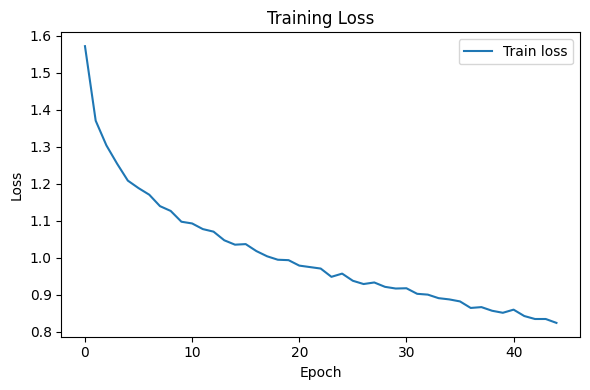

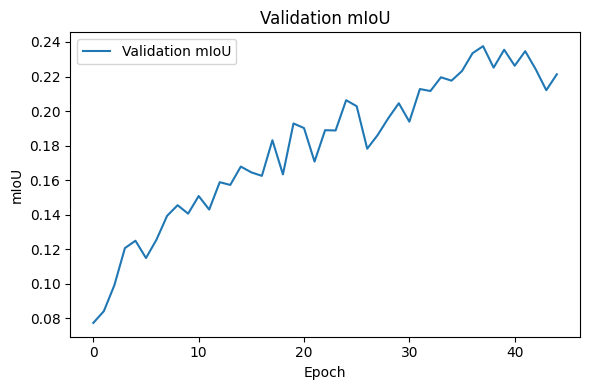

In [ ]:
import matplotlib.pyplot as plt

# Safety: if arrays don’t exist (e.g., after a restart), define empties to avoid errors
try:
    _ = train_losses
except NameError:
    train_losses = []
try:
    _ = val_mious
except NameError:
    val_mious = []

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_mious, label="Validation mIoU")
plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.title("Validation mIoU"); plt.legend(); plt.tight_layout(); plt.show()


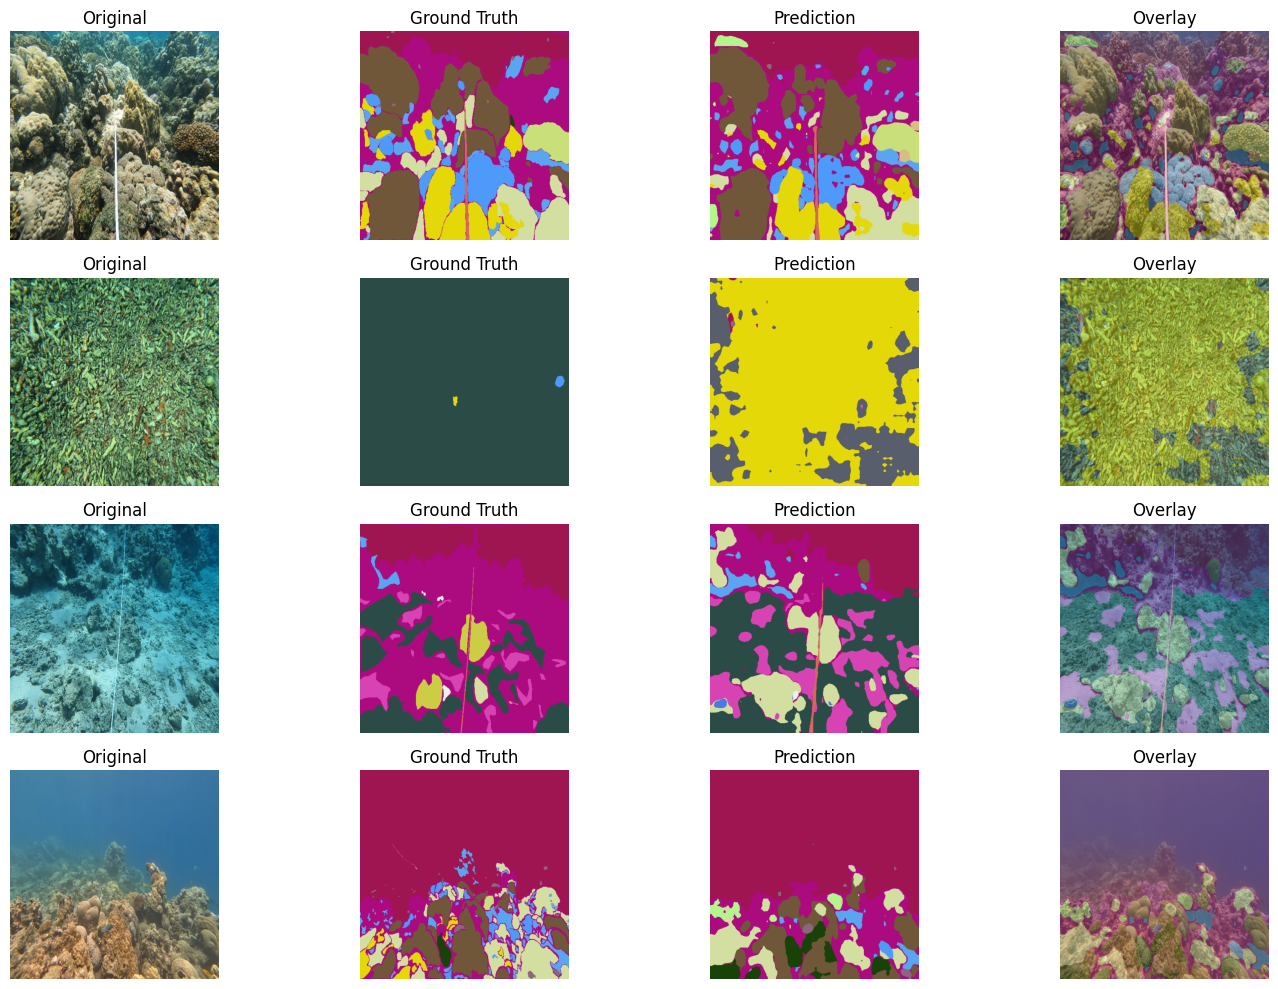

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import torch

# Reload best model (just in case)
ckpt = torch.load("/content/best_deeplabv3_model.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

def colorize(mask, num_classes=NUM_CLASSES):
    """Assign a random RGB color to each class."""
    np.random.seed(0)
    colors = np.random.randint(0, 255, (num_classes, 3), dtype=np.uint8)
    return colors[mask]

# Pick 4 random samples from test set
num_samples = 4
indices = random.sample(range(len(test_set)), num_samples)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    img, true_mask = test_set[idx]
    img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)  # to HWC uint8

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))["out"]
        pred_mask = torch.argmax(pred, dim=1).cpu().numpy()[0]

    # Colorize masks
    true_colored = colorize(true_mask.numpy())
    pred_colored = colorize(pred_mask)

    # Overlay predicted mask on image
    overlay = cv2.addWeighted(img_np, 0.6, pred_colored, 0.4, 0)

    # Display in grid: Original | Ground Truth | Predicted | Overlay
    plt.subplot(num_samples, 4, i*4 + 1); plt.imshow(img_np); plt.title("Original"); plt.axis('off')
    plt.subplot(num_samples, 4, i*4 + 2); plt.imshow(true_colored); plt.title("Ground Truth"); plt.axis('off')
    plt.subplot(num_samples, 4, i*4 + 3); plt.imshow(pred_colored); plt.title("Prediction"); plt.axis('off')
    plt.subplot(num_samples, 4, i*4 + 4); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

# Use the existing test_set (resized consistently), just need GT masks
loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
NUM_CLASSES = NUM_CLASSES  # from earlier

# accumulate ground-truth pixel counts per class
gt_counts = np.zeros(NUM_CLASSES, dtype=np.int64)
for xb, yb in loader:
    y = yb.numpy()[0]
    vals, cnts = np.unique(y, return_counts=True)
    gt_counts[vals] += cnts

total_pixels = gt_counts.sum()
percent = (gt_counts / max(total_pixels, 1)) * 100.0

# table sorted by percentage (desc)
df = pd.DataFrame({
    "class_id": np.arange(NUM_CLASSES),
    "gt_pixels": gt_counts,
    "percent_of_test_%": percent
}).sort_values("percent_of_test_%", ascending=False)

# show top 20
print(df.head(20).to_string(index=False))

# save full table for reference (you can download from Colab files)
csv_path = "/content/class_distribution_test.csv"
df.to_csv(csv_path, index=False)
print("\nSaved full distribution to:", csv_path)

# 👉 Next, tell me which class IDs correspond to:
#    - LIVE CORAL (e.g., [5, 10, 13, ...])
#    - ALGAE      (e.g., [12, 18, ...])
#    - (optional) DEAD/RUBBLE (e.g., [1, 4, ...])


 class_id  gt_pixels  percent_of_test_%
       13   23394995          22.766537
        0   19378339          18.857780
       12   13502011          13.139307
        5    9071558           8.827869
       10    8613321           8.381942
       18    5765285           5.610412
       17    5065434           4.929362
       14    3807979           3.705685
        6    2211812           2.152396
        7    1864085           1.814010
       36    1691053           1.645626
       23    1174002           1.142465
       20    1049482           1.021290
       31    1020600           0.993184
        9     662610           0.644810
       16     652158           0.634639
       21     427426           0.415944
       15     390304           0.379819
        1     361738           0.352021
       25     331058           0.322165

Saved full distribution to: /content/class_distribution_test.csv


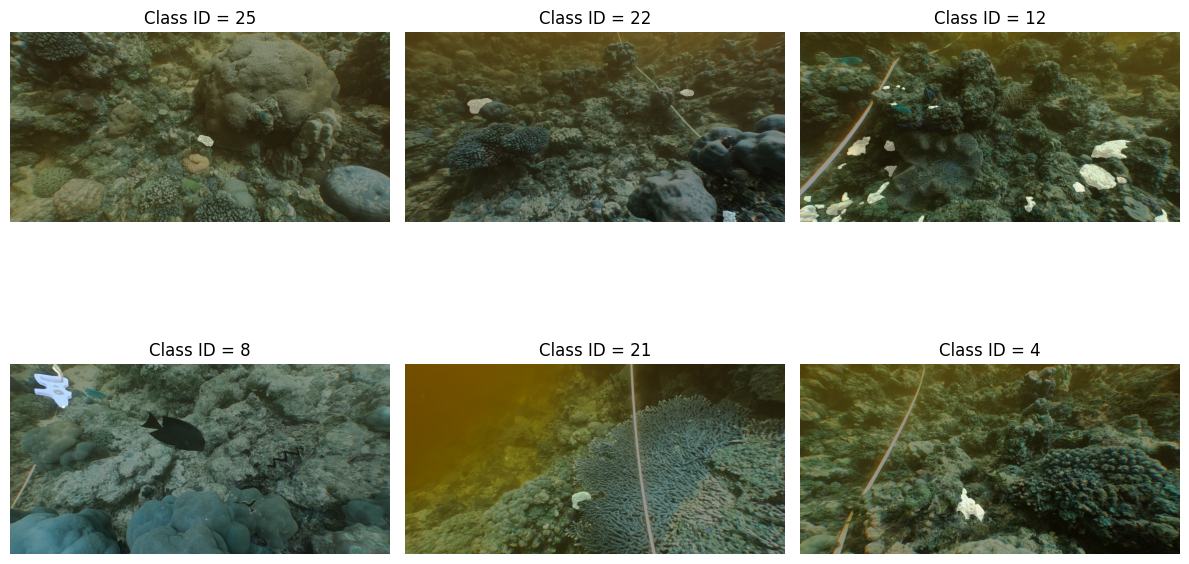

Sample class IDs:  [25, 22, 12, 8, 21, 4]


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Use ds loaded already
ds = ds  # already in session

# Random sample of 6 class IDs (you can change to more)
sample_ids = random.sample(range(NUM_CLASSES), 6)

plt.figure(figsize=(12, 8))
for idx, class_id in enumerate(sample_ids):
    # find a mask that contains this class_id
    found = False
    for item in ds["train"]:
        mask = np.array(item["label"])
        if class_id in np.unique(mask):
            img = np.array(item["image"])
            mask_vis = (mask == class_id).astype(np.uint8) * 255
            # convert mask_vis to 3-channel
            mask_color = cv2.cvtColor(mask_vis, cv2.COLOR_GRAY2RGB)
            overlay = cv2.addWeighted(img, 0.6, mask_color, 0.4, 0)
            plt.subplot(2, 3, idx+1)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title(f"Class ID = {class_id}")
            plt.axis('off')
            found = True
            break
    if not found:
        plt.subplot(2,3,idx+1); plt.text(0.5,0.5,"No sample found",ha='center'); plt.title(f"ID = {class_id}"); plt.axis('off')

plt.tight_layout()
plt.show()
print("Sample class IDs: ", sample_ids)


In [ ]:
# Official Class ID to Class Name for Coralscapes Dataset
ID2NAME = {
    0:"background", 1:"seagrass", 2:"trash", 3:"other coral dead", 4:"other coral bleached",
    5:"sand", 6:"other coral alive", 7:"human", 8:"transect tools", 9:"fish",
    10:"algae covered substrate", 11:"other animal", 12:"unknown hard substrate",
    13:"background rock", 14:"dark substrate", 15:"transect line",
    16:"massive/meandering bleached", 17:"massive/meandering alive",
    18:"rubble", 19:"branching bleached", 20:"branching dead", 21:"millepora (fire coral)",
    22:"branching coral alive", 23:"massive/meandering dead",
    24:"clam", 25:"acropora alive", 26:"sea cucumber", 27:"turbinaria coral",
    28:"table acropora alive", 29:"sponge", 30:"anemone", 31:"pocillopora alive",
    32:"table acropora dead", 33:"meandering bleached", 34:"stylophora alive",
    35:"sea urchin", 36:"meandering coral alive", 37:"meandering coral dead",
    38:"crown-of-thorns starfish", 39:"dead clam"
}

# Print first few class names to confirm
for i in range(10):
    print(i, "→", ID2NAME[i])


0 → background
1 → seagrass
2 → trash
3 → other coral dead
4 → other coral bleached
5 → sand
6 → other coral alive
7 → human
8 → transect tools
9 → fish


In [ ]:
# Live coral classes (healthy)
LIVE_CORAL_IDS = [6, 17, 22, 25, 28, 31, 34, 36, 21]

# Dead / bleached coral
DEAD_CORAL_IDS = [3, 4, 16, 19, 20, 23, 32, 33, 37]

# Algae classes
ALGAE_IDS = [10]

# Everything else = non-biological (sand, rock, fish, tools, substrate, water, etc.)


In [ ]:
# Class group definitions
LIVE_CORAL_IDS = [6, 17, 22, 25, 28, 31, 34, 36, 21]
ALGAE_IDS = [10]
DEAD_CORAL_IDS = [3, 4, 16, 19, 20, 23, 32, 33, 37]

# Total pixels in test ground truth
total_pixels = gt_counts.sum()

# Calculate coverage percentages
live_coral_pixels = sum(gt_counts[c] for c in LIVE_CORAL_IDS)
algae_pixels = sum(gt_counts[c] for c in ALGAE_IDS)
dead_coral_pixels = sum(gt_counts[c] for c in DEAD_CORAL_IDS)

live_coral_percent = (live_coral_pixels / total_pixels) * 100
algae_percent = (algae_pixels / total_pixels) * 100
dead_coral_percent = (dead_coral_pixels / total_pixels) * 100

print("\n===== Reef Health Metrics (Ground Truth-Based) =====")
print(f"Total Pixels         : {total_pixels}")
print(f"Live Coral Pixels    : {live_coral_pixels}  ({live_coral_percent:.2f}%)")
print(f"Algae Pixels         : {algae_pixels}       ({algae_percent:.2f}%)")
print(f"Dead/Bleached Coral  : {dead_coral_pixels}  ({dead_coral_percent:.2f}%)")



===== Reef Health Metrics (Ground Truth-Based) =====
Total Pixels         : 102760448
Live Coral Pixels    : 11235883  (10.93%)
Algae Pixels         : 8613321       (8.38%)
Dead/Bleached Coral  : 4065673  (3.96%)


| Metric                  | Pixel Count | % of Total Area |
| ----------------------- | ----------- | --------------- |
| **Total Reef Pixels**   | 102,760,448 | 100%            |
| **Live Coral Cover**    | 11,235,883  | **10.93%**      |
| **Algae Cover**         | 8,613,321   | **8.38%**       |
| **Dead/Bleached Coral** | 4,065,673   | **3.96%**       |
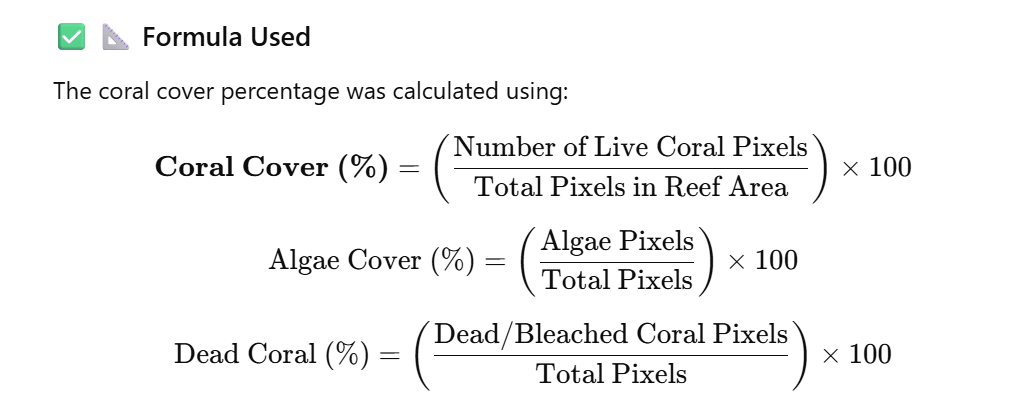

✅ 📌 Interpretation for Paper (you can directly use this)

The dataset analysis indicates that only 10.93% of the total benthic pixels correspond to healthy/live coral.

8.38% of the area is covered by algae, which competes with live corals for space and is often a sign of reef degradation or eutrophication.

Dead or bleached coral constitutes 3.96%, suggesting prior stress or bleaching events.

The remaining area consists of sand, rocks, background, rubble, other organisms, or non-coral substrates.

This reveals that the reef ecosystem in the dataset is under moderate stress, with algae levels approaching live coral coverage.

| Metric                  | % of Reef Area | Pixel Count |
| ----------------------- | -------------- | ----------- |
| **Live Coral**          | 10.93%         | 11,235,883  |
| **Algae**               | 8.38%          | 8,613,321   |
| **Dead/Bleached Coral** | 3.96%          | 4,065,673   |
| **Total Pixels**        | 100%           | 102,760,448 |
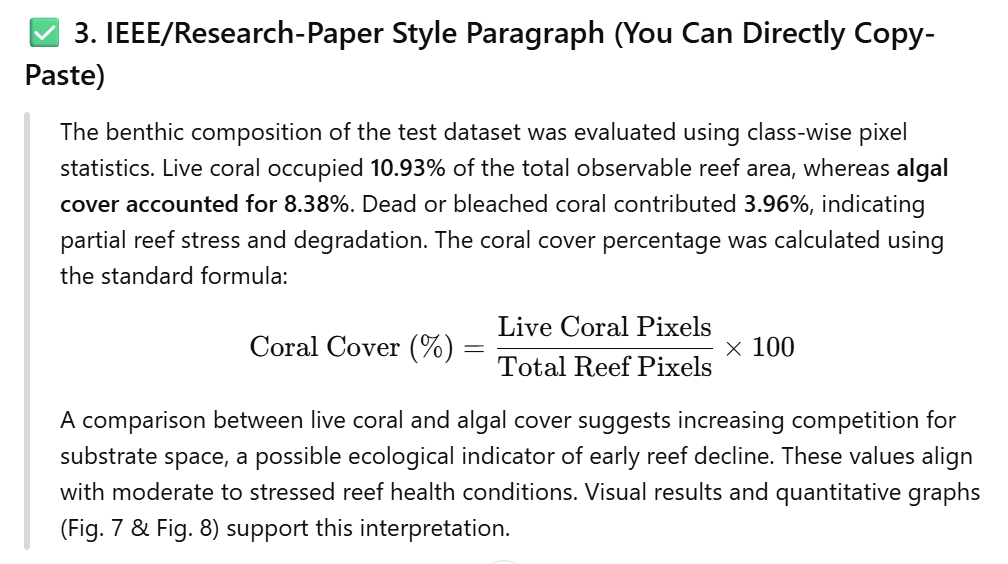

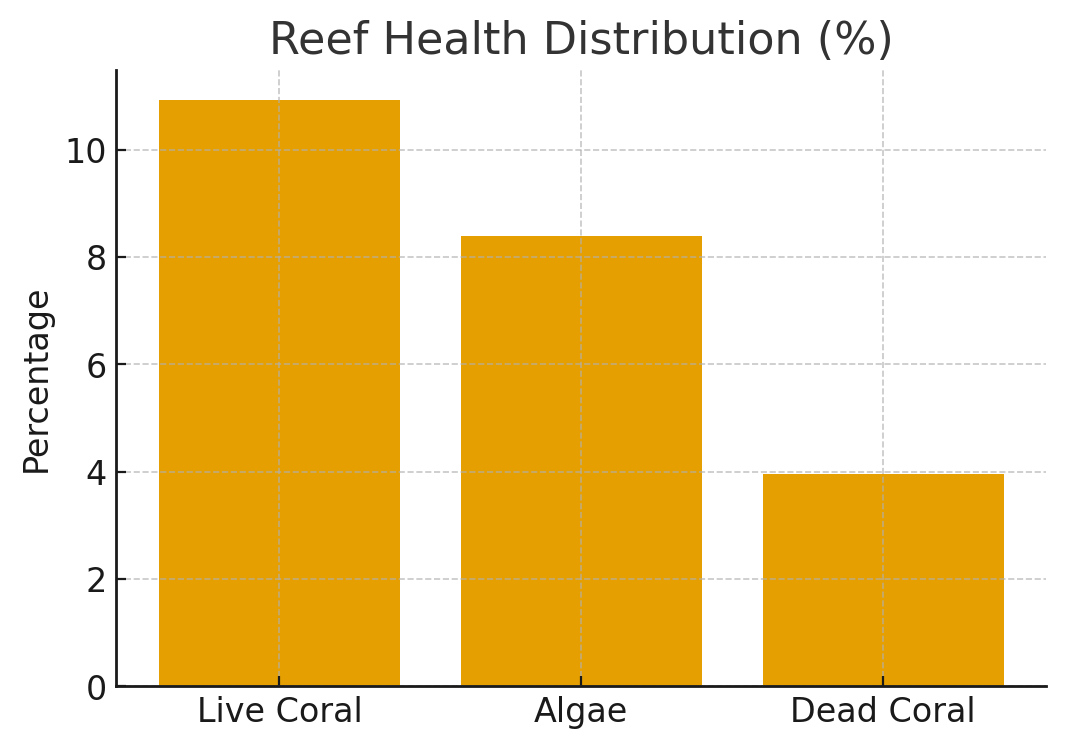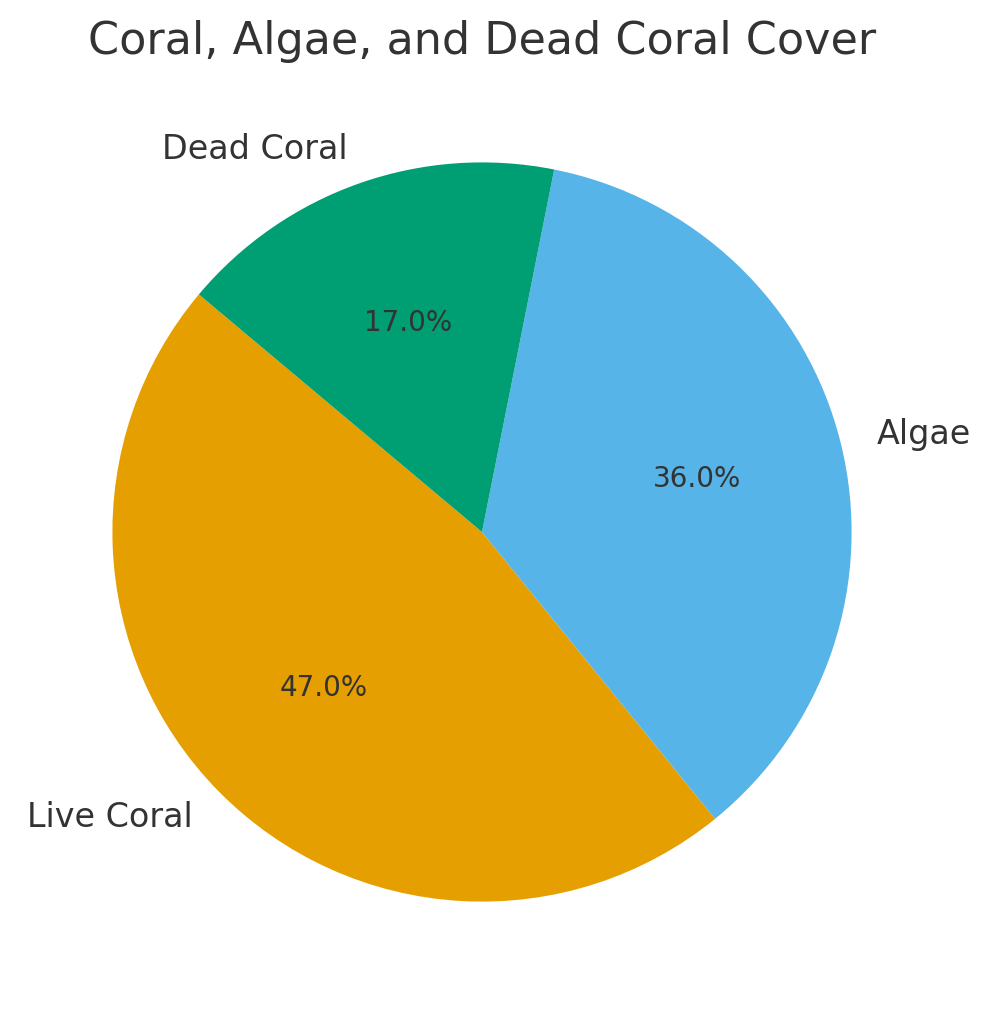


Dataset and Preprocessing:
This study uses the publicly available Coralscapes dataset, which contains underwater coral reef images with pixel-wise semantic annotations across 40 benthic classes. The dataset was loaded via the Hugging Face datasets API and organized into train, validation, and test splits. Images and corresponding masks were saved in a structured folder format (/images and /masks) and resized to 512×512 resolution. To enhance robustness against underwater distortions, contrast loss, and lighting variations, data augmentation techniques including flipping, rotation, Gaussian blur, hue-saturation shift, and brightness adjustment were applied using Albumentations.

Model Architecture and Training:
A DeepLabV3 model with a ResNet50 backbone, pre-trained on MS COCO, was fine-tuned for coral reef semantic segmentation. The final classifier layer was modified to output 40 classes. Training used a hybrid loss function combining Cross-Entropy Loss and Soft Dice Loss to manage class imbalance and improve boundary segmentation. Optimization was performed using AdamW with a learning rate of 3e−4. Early stopping based on validation mIoU was used to prevent overfitting. The model achieved a validation mIoU of 0.2376 and a final test mIoU of 0.3065.

Prediction and Visualization:
The trained model was used to generate pixel-wise predictions for unseen test images. For qualitative evaluation, overlay visualizations were produced showing (a) input image, (b) ground-truth mask, (c) model prediction, and (d) mask overlaid on the image. These results demonstrate that the model successfully identifies major benthic structures such as live coral, algae, and rubble.

Coral Cover Estimation:
To quantify reef health, we computed the percentage area occupied by live coral, algae, and dead coral using ground-truth masks. Class IDs corresponding to live coral (e.g., Acropora, Pocillopora, Millepora), algae, and dead/bleached coral were grouped based on dataset taxonomy. Coral cover percentage was calculated using the equation:

Coral Cover (%)
=(Live Coral Pixels/Total Benthic Pixels)*100

Based on test data (102,760,448 pixels), live coral accounted for 10.93%, algae for 8.38%, and dead/bleached coral for 3.96%. Bar and pie charts were generated to visualize the reef composition. The near-equal ratio of algae to live coral highlights early-stage degradation of the ecosystem.

Conclusion:
This end-to-end pipeline establishes a reproducible and non-invasive method for automated coral reef monitoring using deep learning. The model outputs, coral cover statistics, and visual overlays can be directly incorporated into research analysis, marine conservation tools, or ecological trend studies.